<a href="https://colab.research.google.com/github/jx-dohwan/-Deep_Learning_from_Scratch_2_study/blob/main/CH4_Word2vec%EC%86%8D%EB%8F%84%EA%B0%9C%EC%84%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CH4_Word2vec속도개선
- Embedding이라는 새로운 계층을 도입
- 네거티브 샘플링이라는 새로운 손실 함수를 도입

## 1. word2vec개선

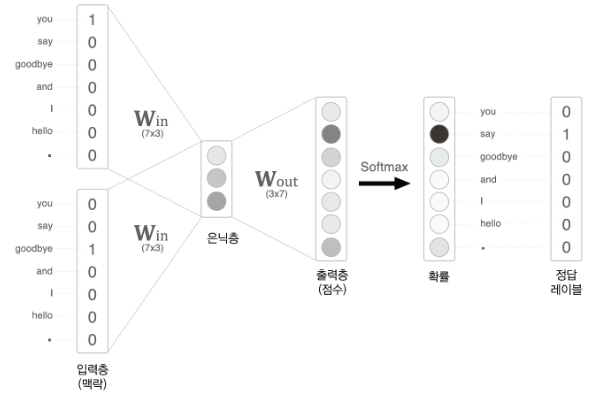

> 위의 모델은 작은 데이터에서는 문제가 없다. 하지만 거대한 말뭉치를 다루게 되면 몇 가지 문제가 발생한다. 입력층과 출력층에는 각 100만 개의 뉴런이 존재한다면 이 수 많은 뉴런 때문에 중간 계산에 많은 시간이 소요된다. 정확히는 다음의 두 계산이 병목이 된다.
- 입력층의 원핫 표현과 가중치 행렬 Win의 곱을 계산이 병
- 은닉층과 가중치 행렬 Wout의 곱 및 Softmax 계층의 계산

> 첫번째는 입력층의 원핫 표현과 관련된 문제이다. 단어를 원핫 표현으로 다루기 때문에 어휘 수가 많아지면 원핫 표현의 벡터 크기도 커지는 것이다. 예를 들어 100만 개라면 그 원핫 표현 하나만 해도 원소 수가 100만 개인 벡터가 된다. 그러면 상당한 메모리를 차지하게 된다. 게다가 이 원핫 벡터와 가중치 행렬 Win을 곱해야 하는데, 이것만으로 계산 자원을 상당히 사용하게 된다. 그래서 이번 절에서 제시한 것이 Embedding 계층을 도입하는 것이다. <br><br> 두번째 문제는 은닉층 이후의 계산이다. 우선 은닉층과 가중치 행렬 Wout의 곱만 해도 계산량이 상당하다. 그리고 Softmax 계층에서도 다루는 어휘가 많아짐에 따라 계산량이 증가하는 문제가 있다. 이 문제는 네거티브 샘플링이라는 새로운 손실함수를 도입해서 해결할 수 있다.



### 1) Embedding 계층
> 앞 장의 word2vec 구현에서는 단어를 원핫 표현으로 바꿨다. 그리고 그것을 MatMul 계층에 입력하고, MatMul 계층에서 가중치 행렬을 곱했다. 그럼 여기서 어휘 수가 100만개인 경우를 상상해보자. 이때 은닉층 뉴런이 100개라면 MatMul 계층의 행렬 곱처럼 된다. 

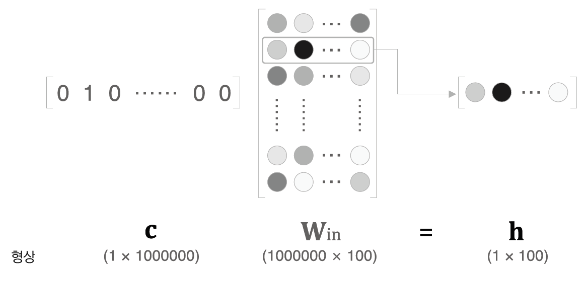

>100만개의 어휘를 담은 말뭉치가 있다면, 단어의 원핫 표현도 100만 차원이 된다. 그리고 이런 거대한 벡터와 가중치 행렬을 곱해야하는 것이다. 그러나 결과적으로 수행하는 일은 단지 행렬의 특정 행을 추출하는 것뿐이다. 따라서 원핫 표현으로의 변환과 MatMul 계층의 행렬 곱 계산은 사실 필요가 없는 것이다. <br><br> 그러면 가중치 매개변수로부터 단어 ID에 해당하는 행(벡터)를 추출하는 계층을 만들어 보자 그 계층을 Embedding 계층이라고 부른다. 참고로 Embedding이란 단어 임베딩(word embedding)에서 유래했다. 즉, Embedding 계층에 단어 임베딩(분산 표현)을 저장하는 것이다 .

### 2) Embedding 계층 구현
> 행렬에서 특정 행을 추출하기란 아주 쉽다. 예컨대 가중치 W가 2차원 넘파이 배열일 때, 이 가중치로부터 특정 행을 추출하려면 그저 W[2]나 W[5]처럼 원하는 행을 명시하면 끝이다.

In [1]:
import numpy as np
W = np.arange(21).reshape(7,3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [2]:
W[2]

array([6, 7, 8])

In [3]:
W[5]

array([15, 16, 17])

In [4]:
idx = np.array([1, 0, 3, 0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [6]:
# forward() 메서드를 구현해보자 
class Embedding:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.idx = None # idx에는 추출하는 행의 인덱스를 배열로 저장한다. 

  def forward(self, idx):
    W, = self.params 
    self.idx = idx
    out = W[idx]
    return out 

> Embedding 계층의 순전파는 가중치 W의 특정 행을 추출할 뿐이었다. 단순히 가중치의 특정 행 뉴런만(아무것도 손대지 않고)다음 층으로 흘려보낸 것이다.

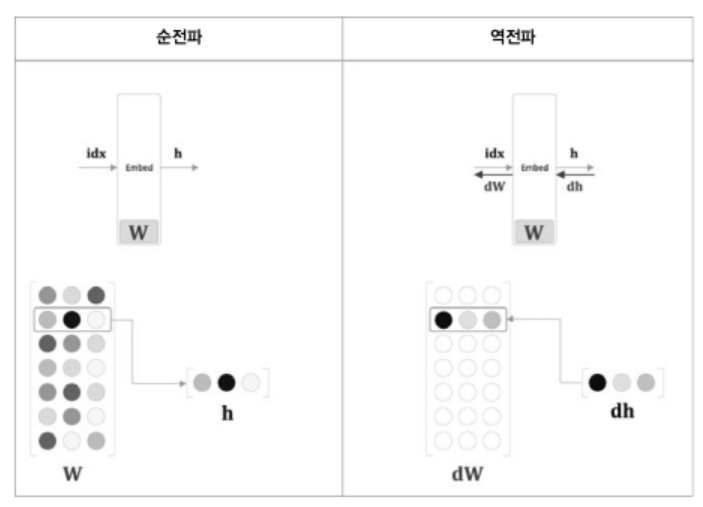

In [8]:
def backward(self, dout):
  dW = self.grads 
  dW[...] = 0
  dW[self.idx] = dout
  return None 

> 역전파에서는 앞 층(출력 측 층)으로부터 전해진 기울기를 다음 층으로 그대로 흘려주면 된다. 다만, 앞 층으로부터 전해진 기울기를 가중치 기울기 dW의 특정 행에 설정한다. <br><br> 이 코드는 가중치 기울기 dW를 꺼낸 다음 dW[...] = 0 문장에서 dW의 원소를 0으로 덮어쓴다(dw 자체를 0으로 설정하는 게 아니라. dW의 형상을 유지한 채, 그 원소들을 0으로 덮어쓰는 것이다.) 그리고 앞 층에서 전해진 기울기 dout을 idx번재 행에 할당한다.

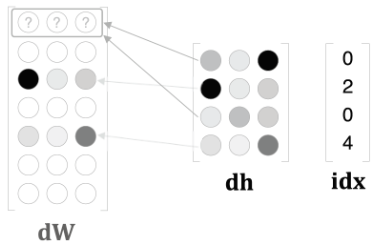

- 문제는 앞의 backward()를 구현하는 데는 사실 문제가 하나 더 있다. 그 문제는 idx의 원소가 중복될 때 발생한다. 
- 위의 그림과 같이 dh의 각 행 값을 idx가 가리키는 장소에 할당해보겠다. 
- 그러면 dW의 0번째 행에 2개의 값이 할당된다. 먼저 쓰여진 값을 덮어쓴다는 뜻이다. 
- 이 중복 문제를 해결하려면 '할당'이 아닌 '더하기'를 해야한다.
- 즉, dh의 각 행의 값을 dW의 해당 행에 더해준다.

> 그러면 이제 역전파를 다시 올바르게 구현해보자

In [9]:
def backward(self, dout):
  dW, = self.grads
  dW[...] = 0

  for i, word_id in enumerate(self.idx):
    dW[word_id] += dout[i]
    # 혹은
    # np.add.at(dW, self.idx, dout)

    return None 

- 여기에서 for문을 사용해 해당 인덱스에 기울기를 더했다. 이것으로 idx에 중복 인덱스가 있더라도 올바르게 처리된다.
- 참고로, for문 대신 넘파이 np.add.at()을 사용해도 된다 
  - np.add.at(A, idx, B)는 B를 A의 idx번재 행에 더해준다.

> 일반적으로 파이썬에서 for문보다 넘파이의 내장 메서드를 사용하는 편이 더 빠르다. 넘파이의 메서드에는 속도와 효율을 높여주는 최적화가 적용돼 있기 때문이다. 따라서 앞의 소스 코드도 for문 대신 np.add.at()을 사용하도록 수정하면 효율이 훨씬 좋아진다. 

> 지금까지 MatMul 계층을 Embedding 계층으로 전환했다. 그 효과로 메모리 사용량을 줄이고 쓸데없는 계산도 생략할 수 있게 되었다. 